### Calculate direct and diffuse irradiance at the surface and the top of the atmosphere

In [ ]:
# general imports
import subprocess
import numpy as np
import matplotlib.pyplot as plt

# result imports
import eradiate
#eradiate.config.settings.progress = "spectral_loop"
eradiate.set_mode("ckd")
from eradiate.units import unit_registry as ureg
from eradiate import scenes as ertsc


In [44]:
import pint
import xarray as xr
def load_aerosol_data(data_path: str, particle_shape: str, wavelength: pint.Quantity):
    
    # Load aerosol component dataset
    file = xr.open_dataset(data_path)
    data = file.copy()

    # phase raw shape is [wavelenth, phase, theta]
    # reshape to target [wavelenth, theta, phase]
    phase_da = data.phase.isel(nreff=0).dropna(dim="nthetamax")
    phase_raw = phase_da.transpose("nlam", "nthetamax", "nphamat").values

    n_wavelength = phase_da.nlam.shape[0]
    n_theta = phase_da.nthetamax.shape[0]

    # target shape is [wavelength, theta, i, j]
    phase_np = np.zeros((n_wavelength, n_theta, 4, 4))

    if particle_shape == "spherical":
        phase_np[:, :, 0, 0] = phase_raw[:, :, 0]
        phase_np[:, :, 1, 1] = phase_raw[:, :, 0]
        phase_np[:, :, 0, 1] = phase_raw[:, :, 1]
        phase_np[:, :, 1, 0] = phase_raw[:, :, 1]
        phase_np[:, :, 2, 2] = phase_raw[:, :, 2]
        phase_np[:, :, 3, 3] = phase_raw[:, :, 2]
        phase_np[:, :, 2, 3] = phase_raw[:, :, 3]
        phase_np[:, :, 3, 2] = phase_raw[:, :, 3]
    elif particle_shape == "spheroidal":
        phase_np[:, :, 0, 0] = phase_raw[:, :, 0]
        phase_np[:, :, 0, 1] = phase_raw[:, :, 1]
        phase_np[:, :, 1, 0] = phase_raw[:, :, 1]
        phase_np[:, :, 1, 1] = phase_raw[:, :, 4]
        phase_np[:, :, 2, 2] = phase_raw[:, :, 2]
        phase_np[:, :, 2, 3] = phase_raw[:, :, 3]
        phase_np[:, :, 3, 2] = phase_raw[:, :, 3]
        phase_np[:, :, 3, 3] = phase_raw[:, :, 5]
    else:
        NotImplementedError

    # populate the eradiate dataset that has the correct format
    phase_eradiate = xr.Dataset(
        data_vars={
            "sigma_t": (["w"], data.ext.isel(nreff=0).values, {"units": "1/km"}),
            "albedo": (["w"], data.ssa.isel(nreff=0).values, {"units": ""}),
            "phase": (["w", "mu", "i", "j"], phase_np),
        },
        coords={
            "w": ("w", [wavelength.m_as("micron") - 0.1], {"units": "um"}),
            "mu": (
                "mu",
                np.cos(
                    np.deg2rad(
                        data.theta.isel(
                            nlam=0, nreff=0, nphamat=0, nthetamax=phase_da.nthetamax
                        ).values
                    )
                ),
            ),
            "i": ("i", range(4)),
            "j": ("j", range(4)),
        },
    )

    # This is a hack, do it a second time with a different wavelength
    # and concatenate so that eradiate can still do some interpolation
    phase_eradiate_2 = xr.Dataset(
        data_vars={
            "sigma_t": (["w"], data.ext.isel(nreff=0).values, {"units": "1/km"}),
            "albedo": (["w"], data.ssa.isel(nreff=0).values, {"units": ""}),
            "phase": (["w", "mu", "i", "j"], phase_np),
        },
        coords={
            "w": ("w", [wavelength.m_as("micron") + 0.1], {"units": "um"}),
            "mu": (
                "mu",
                np.cos(
                    np.deg2rad(
                        data.theta.isel(
                            nlam=0, nreff=0, nphamat=0, nthetamax=phase_da.nthetamax
                        ).values
                    )
                ),
            ),
            "i": ("i", range(4)),
            "j": ("j", range(4)),
        },
    )

    phase_eradiate = xr.concat([phase_eradiate, phase_eradiate_2], dim="w")
    return phase_eradiate


In [56]:


# define function to run the experiment
def run_exp(albedo=0.2, aod=0.0, wavelength=550.0, ground_elevation=0.0, spp=10000, integrator=None):

    """
    Run irradiance spectrum
    """

    if integrator is None:
        integrator = ertsc.integrators.VolPathIntegrator( )

    # Location of reference panel used to compute BOA incoming flux
    REFERENCE_PANEL_LOCATION = [1000.0, 1000.0, ground_elevation + 0.1] * ureg.m

    
    aerosol_layer = ertsc.atmosphere.ParticleLayer(tau_ref=aod,
                                                    bottom=0* ureg.m, 
                                                    top=2*ureg.km,
                                                    distribution="uniform",
                                                    w_ref=wavelength,
                                                    dataset='govaerts_2021-desert-extrapolated',
                                                    )  
    
    phase_data = load_aerosol_data(
            'watercloud.mie.cdf', "spherical", 800 * ureg.nm )
    
    cloud_layer = ertsc.atmosphere.ParticleLayer(
            bottom=1 * ureg.km,
            top=2 * ureg.km,
            tau_ref=aod,
            w_ref=wavelength,
            distribution="uniform",
            dataset=phase_data,
            particle_shape="spherical",
        )

    
    # Define the atmosphere and illumination conditions
    atmosphere={
        "type": "heterogeneous",
        "molecular_atmosphere": {  # Clear-sky component
            "thermoprops": {
                "identifier": f"afgl_1986-midlatitude_summer",
                "z": np.linspace(0.0, 120.0, 1201) * ureg.km,
                },
            "absorption_data": "mycena", # CKD parameterization with 10nm spectral resolution
        },
        "particle_layers":[cloud_layer]
    }   

     

    # sun position, illumination     
    illumination={
        "type": "directional",
        "zenith": 30,
        "azimuth": 0,
        "irradiance":1.0
    }

    # Define two "distant flux" measures to compute down- and upwelling flux at the reference panel location
    measures=[
        {
        "type": "distant_flux",
        "id": "distant_flux_boa_up",
        "target": REFERENCE_PANEL_LOCATION,
        "ray_offset": 1.0 * ureg.cm,
        "spp": spp,
        "film_resolution": (1, 1),
        "direction": [0,0,-1],
        "srf": {"type": "multi_delta", "wavelengths": wavelength},
        },      

        {
        "type": "distant_flux",
        "id": "distant_flux_boa_down",
        "target": REFERENCE_PANEL_LOCATION,
        "ray_offset": 1.0 * ureg.cm,
        "spp": spp,
        "film_resolution": (1, 1),
        "direction": [0,0,1],
        "srf": {"type": "multi_delta", "wavelengths": wavelength},
        },   
    ]

    
    exp = eradiate.experiments.AtmosphereExperiment( 
        surface={
            "type": "lambertian",
            "reflectance": albedo,
        },
        illumination=illumination,
        atmosphere=atmosphere, 
        measures=measures, 
        integrator=integrator,   
    )

    return eradiate.run(exp)

In [57]:
results = []

for albedo in np.arange(1,5.1,1): # [0.0, 0.2, 0.5, 0.8, 1.0]:
    print(f"Running experiment with albedo: {albedo}")
    results.append(run_exp(albedo=0.2, aod=albedo, wavelength=800, ground_elevation=0.0, spp=10000, integrator=None))

Running experiment with albedo: 1.0


0/16|          | 00:00, ETA=?

Running experiment with albedo: 2.0


0/16|          | 00:00, ETA=?

Running experiment with albedo: 3.0


0/16|          | 00:00, ETA=?

Running experiment with albedo: 4.0


0/16|          | 00:00, ETA=?

Running experiment with albedo: 5.0


0/16|          | 00:00, ETA=?

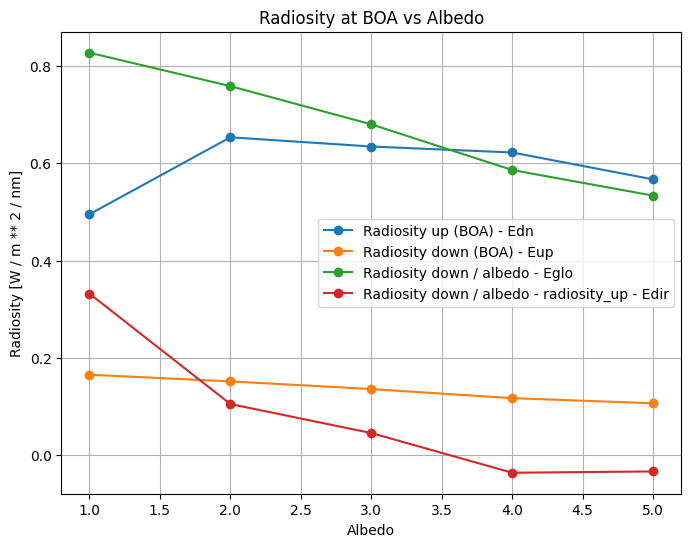

In [58]:
# Extract radiosity values for each albedo for both upwelling and downwelling fluxes
albedo_values = np.arange(1,5.1,1) # np.array([0.0, 0.2, 0.5, 0.8, 1.0])
radiosity_up = [res['distant_flux_boa_up'].radiosity.values[0,0,0] for res in results]
radiosity_down = [res['distant_flux_boa_down'].radiosity.values[0,0,0] for res in results]


plt.figure(figsize=(8, 6))
plt.plot(albedo_values, radiosity_up, marker='o', label='Radiosity up (BOA) - Edn')
plt.plot(albedo_values, radiosity_down, marker='o', label='Radiosity down (BOA) - Eup ')
plt.plot(albedo_values, radiosity_down/np.array([0.2]), marker='o', label='Radiosity down / albedo - Eglo')
plt.plot(albedo_values, radiosity_down/np.array([0.2])- radiosity_up, marker='o', label='Radiosity down / albedo - radiosity_up - Edir')
plt.xlabel('Albedo')
plt.ylabel(f'Radiosity [{results[0]["distant_flux_boa_down"].radiosity.units}]')
plt.title('Radiosity at BOA vs Albedo')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
results

[{'distant_flux_boa_up': <xarray.Dataset> Size: 112B
  Dimensions:           (sza: 1, saa: 1, w: 1, y_index: 1, x_index: 1)
  Coordinates:
    * sza               (sza) int64 8B 30
    * saa               (saa) int64 8B 0
    * w                 (w) float64 8B 550.0
    * y_index           (y_index) int64 8B 0
      y                 (y_index) float64 8B 0.0
    * x_index           (x_index) int64 8B 0
      x                 (x_index) float64 8B 0.0
      vza               (x_index, y_index) float64 8B 0.0
      vaa               (x_index, y_index) float64 8B 0.0
      bin_wmin          (w) float64 8B 545.0
      bin_wmax          (w) float64 8B 555.0
  Data variables:
      sector_radiosity  (w, y_index, x_index, saa, sza) float64 8B 0.1088
      irradiance        (sza, saa, w) float64 8B 1.652
      radiosity         (w, saa, sza) float64 8B 0.1088,
  'distant_flux_boa_down': <xarray.Dataset> Size: 112B
  Dimensions:           (sza: 1, saa: 1, w: 1, y_index: 1, x_index: 1)
  Coordin

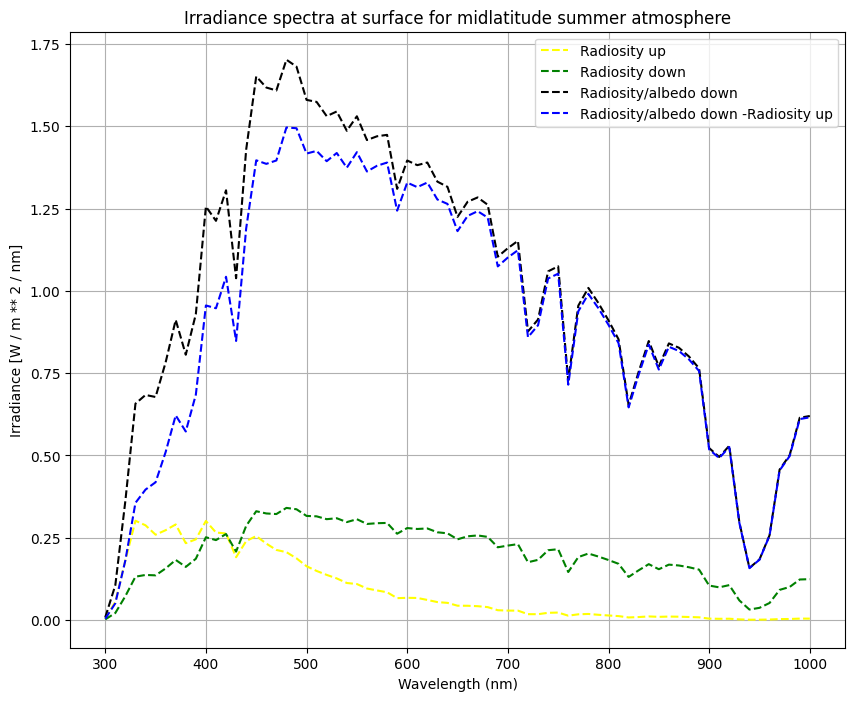

In [8]:
plt.figure(figsize=(10, 8))

plt.plot(results['distant_flux_boa_up'].w[:], results['distant_flux_boa_up'].radiosity[:,0,0], label='Radiosity up', color='yellow', linestyle='--')
plt.plot(results['distant_flux_boa_down'].w[:], results['distant_flux_boa_down'].radiosity[:,0,0], label='Radiosity down', color='green', linestyle='--')
plt.plot(results['distant_flux_boa_down'].w[:], results['distant_flux_boa_down'].radiosity[:,0,0]*5, label='Radiosity/albedo down', color='black', linestyle='--')
plt.plot(results['distant_flux_boa_down'].w[:], (results['distant_flux_boa_down'].radiosity[:,0,0]*5-results['distant_flux_boa_up'].radiosity[:,0,0]), label='Radiosity/albedo down -Radiosity up', color='blue', linestyle='--')
plt.xlabel('Wavelength (nm)')
units = results['distant_flux_boa_down'].radiosity.units
plt.ylabel(f'Irradiance [{units}]')
plt.title('Irradiance spectra at surface for midlatitude summer atmosphere')
plt.legend()
plt.grid()
#plt.xlim(350, 400)



In [ ]:
eradiate_1